In [2]:
# pip install prody torch torch_geometric numpy scipy
from typing import Dict, List, Tuple, Optional
import numpy as np
from scipy.spatial import cKDTree

import prody as pr
import torch
from torch_geometric.data import HeteroData

# ---------------------------
# Utilities
# ---------------------------


In [3]:
cd /home/dmoi/projects/foldtree2/

/home/dmoi/projects/foldtree2


In [4]:

AA_THREE_TO_ONE = {
	'ALA':'A','ARG':'R','ASN':'N','ASP':'D','CYS':'C','GLN':'Q','GLU':'E','GLY':'G',
	'HIS':'H','ILE':'I','LEU':'L','LYS':'K','MET':'M','PHE':'F','PRO':'P','SER':'S',
	'THR':'T','TRP':'W','TYR':'Y','VAL':'V','SEC':'U','PYL':'O'
}

# Basic chemistry lists (tweak as needed)
NEGATIVE = {'ASP','GLU'}
POSITIVE = {'ARG','LYS','HIS'}
AROMATIC = {'PHE','TYR','TRP','HIS'}

def residue_key(res):
	"""Stable residue key: (chainID, resnum, icode)."""
	return (res.getChid(), int(res.getResnum()), (res.getIcode() or '').strip())

def one_letter(resname: str) -> str:
	return AA_THREE_TO_ONE.get(resname.upper(), 'X')

# ---------------------------
# ProDy â†’ residue graph
# ---------------------------


In [20]:

def load_structure(pdb_path: str,
				   model_index: int = 0,
				   atomsel: str = 'protein and not altloc B-Z') -> pr.AtomGroup:
	res = pr.addMissingAtoms(pdb_path, method='openbabel')
	print(res)
	ag = pr.parsePDB(res)

	#ag.addMissingAtoms()
	atoms = ag.select('protein')
	return atoms
# ---------------------------
# Interaction detection
# ---------------------------
def get_interaction_object(ag: pr.AtomGroup ) -> pr.Interactions:
	interactions = pr.Interactions()
	all_interactions = interactions.calcProteinInteractions(ag)
	return all_interactions , interactions

def interaction_matrix_energy(ag):
	return pr.Interactions.buildInteractionMatrixEnergy(ag)


In [21]:
#load structure and get interactions
ag = load_structure('/home/dmoi/projects/foldtree2/foldtree2/config/1eei.pdb')
interactionlist, interactionobj = get_interaction_object(ag)



@> WARNING outfile /home/dmoi/projects/foldtree2/foldtree2/config/addH_1eei.pdb already exists, so returning it. Set overwrite=True to overwrite it
@> 9695 atoms and 1 coordinate set(s) were parsed in 0.09s.
@> Calculating interactions.


/home/dmoi/projects/foldtree2/foldtree2/config/addH_1eei.pdb


@> Calculating hydrogen bonds.
@>      DONOR (res chid atom)   <--->       ACCEPTOR (res chid atom)    Distance  Angle
@>      ARG67    E      NH1_1344  <--->      ASP70    F      OD1_2183     2.5    15.9
@>      SER26    F       OG_1838  <--->      THR41    F      OG1_1953     2.5    38.9
@>      THR78    H      OG1_3877  <--->      ILE74    H        O_3842     2.5    14.3
@>      ALA97    E        N_1582  <--->      CYS86    E        O_1496     2.5    21.3
@>      ALA97    F        N_2396  <--->      CYS86    F        O_2310     2.6    21.1
@>      ASN89    E        N_1520  <--->      ASN14    E         O_921     2.6    34.8
@>      GLU83    D       OE1_660  <--->     SER100    D        OG_791     2.6    32.6
@>      THR41    H      OG1_3581  <--->      SER26    H       OG_3466     2.6    36.2
@>      SER26    H       OG_3466  <--->      THR41    H      OG1_3581     2.6    38.8
@>      THR41    D       OG1_325  <--->      SER26    D        OG_210     2.6    35.8
@>      TRP88    G   

In [22]:
ematrix = interactionobj.buildInteractionMatrixEnergy()

@> Calculating interaction energies matrix with type IB_solv


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


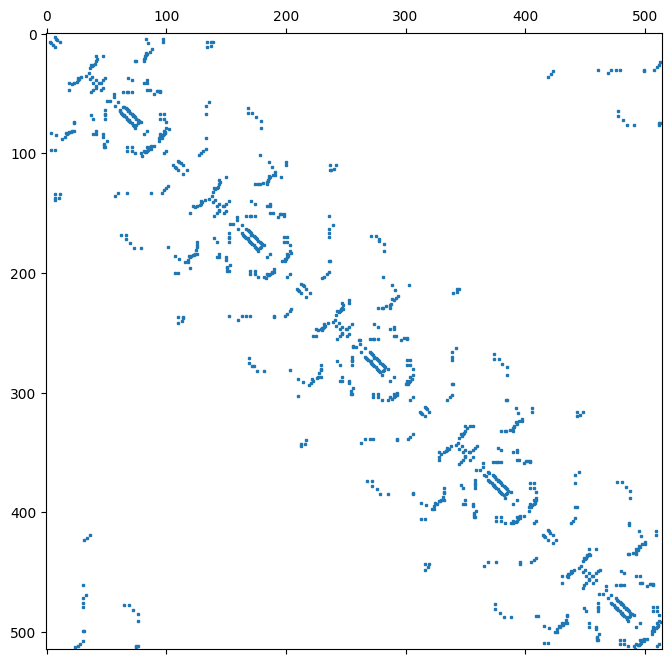

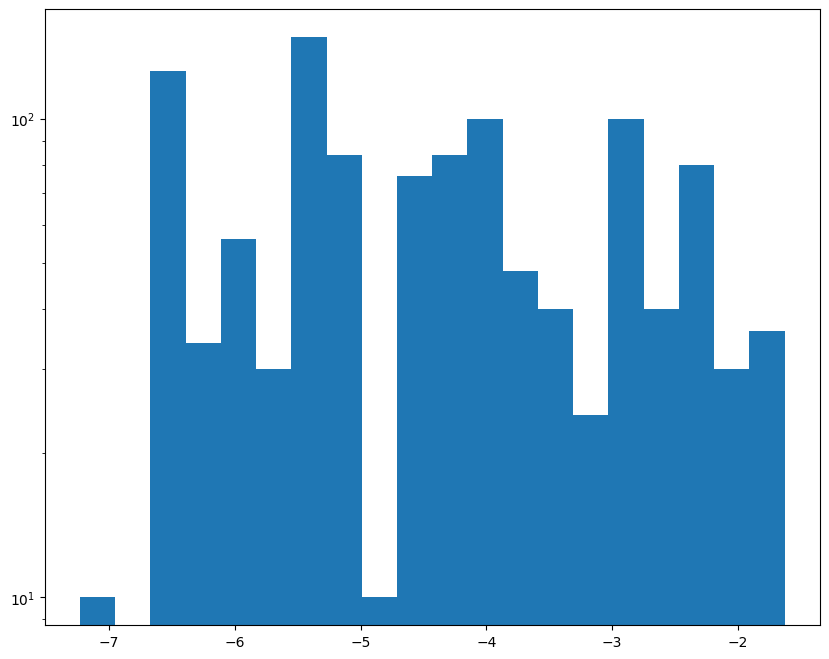

In [34]:
print(ematrix)
from matplotlib import pyplot as plt

plt.figure(figsize=(10,8))
plt.spy(ematrix , markersize=2	)

plt.show()

plt.figure(figsize=(10,8))
#histogram of non zero values
plt.hist(ematrix[ematrix!=0].flatten(), bins=20	)
plt.yscale('log')
plt.show()

@> Calculating interaction matrix


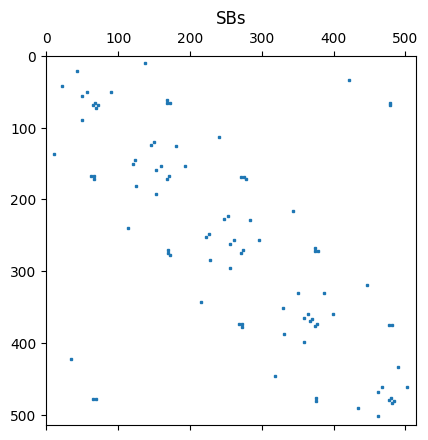

@> Calculating interaction matrix


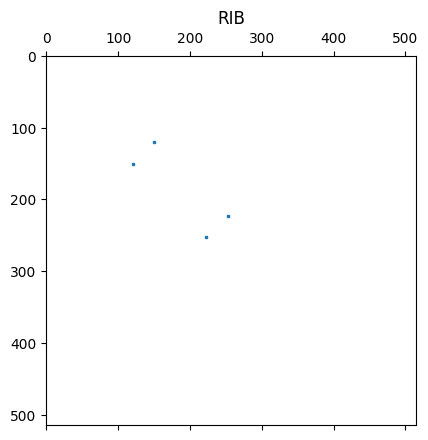

@> Calculating interaction matrix


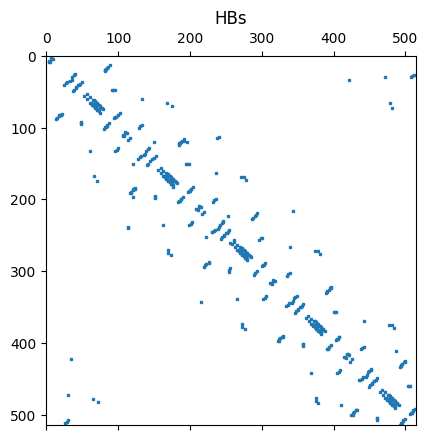

@> Calculating interaction matrix


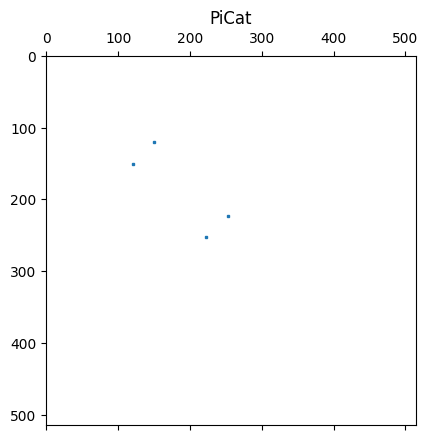

@> Calculating interaction matrix


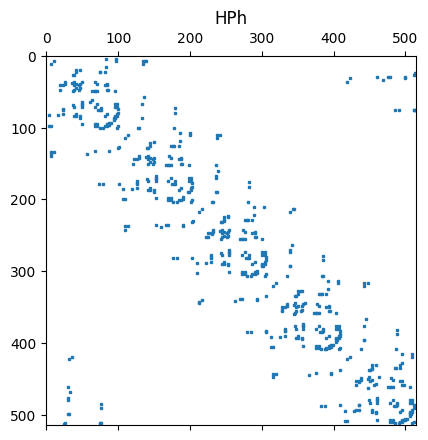

@> Calculating interaction matrix


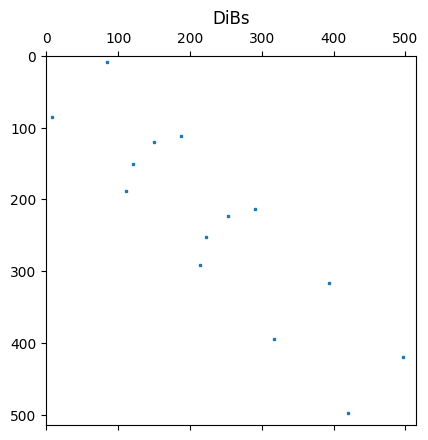

In [35]:
# loop through interactions types and show energy matrices
types = ['SBs' , 'RIB', 'HBs','PiCat', 'HPh', 'DiBs']
stack = []
for t in types:
	#zero out all but one type
	params = {tp:0 for tp in types}
	params[t] = 1
	matrix = interactionobj.buildInteractionMatrix(**params)
	stack.append(matrix)
	plt.figure()
	plt.title(t)
	plt.spy(matrix , markersize=2)
	plt.show()

@> Hessian was built in 0.22s.
@> 20 modes were calculated in 0.26s.
@> Calculating stiffness matrix.
@> 20 modes were calculated in 0.26s.
@> Calculating stiffness matrix.
@> Stiffness matrix calculated in 0.03s.
@> Stiffness matrix calculated in 0.03s.
@> The range of effective force constant is: 1.3356578713622225 to 3.0043886872988783.
@> The range of effective force constant is: 1.3356578713622225 to 3.0043886872988783.
/tmp/ipykernel_342160/823159508.py:9: RuntimeWarning: divide by zero encountered in log
  plt.imshow( np.log(stiffness) , cmap='jet_r')
/tmp/ipykernel_342160/823159508.py:9: RuntimeWarning: divide by zero encountered in log
  plt.imshow( np.log(stiffness) , cmap='jet_r')


[[0.         2.30966204 2.49514047 ... 2.23296736 2.12094886 1.98618861]
 [2.30966204 0.         2.2726863  ... 2.13710432 2.0400553  1.94165504]
 [2.49514047 2.2726863  0.         ... 2.03645931 1.96699216 1.8946146 ]
 ...
 [2.23296736 2.13710432 2.03645931 ... 0.         2.22426802 2.26524241]
 [2.12094886 2.0400553  1.96699216 ... 2.22426802 0.         2.30362312]
 [1.98618861 1.94165504 1.8946146  ... 2.26524241 2.30362312 0.        ]]


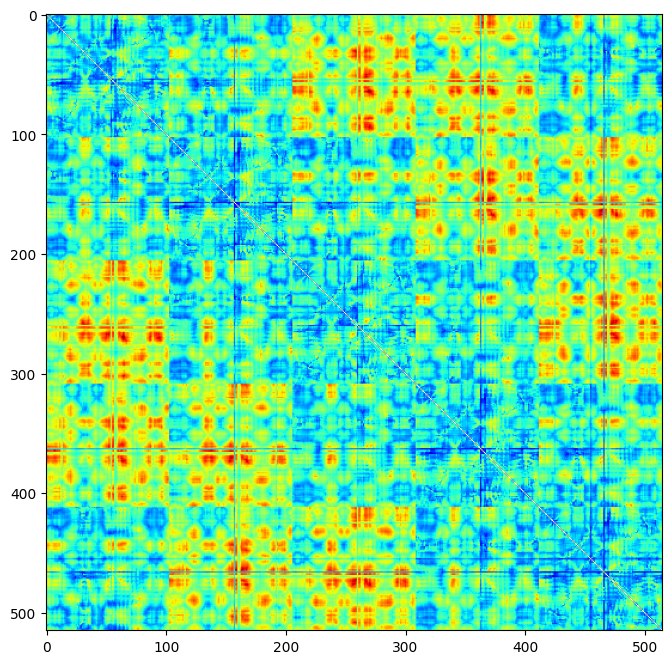

In [44]:
alphas = ag.ca
anm = pr.ANM('ANM analysis')
anm.buildHessian(alphas)
anm.calcModes(n_modes=20)
stiffness = pr.calcMechStiff(anm, alphas)
print(stiffness)
#show = pr.showMechStiff(stiffness, alphas, cmap='jet_r')
plt.figure(figsize=(10,8))
plt.imshow( np.log(stiffness) , cmap='jet_r')
plt.show()